### <center> EEG Signal Classification in Asynchronous BCIs <br /> A Journey from Time Embedding to Convolutional Networks </center>
<center>2016 International BCI Meeting Workshop on <br />
Deep Learning and other Machine Learning and Signal Processing <br />
Methods for Analyzing EEG in BCI Paradigms<center>
<br />
<center>Elliott Forney, Charles Anderson, William Gavin and Patricia Davies</center>
<br />
<center>www.cs.colostate.edu/eeg</center>
<center>eeg@cs.colostate.edu</center>
<center>elliott.forney@gmail.com</center>


Asynchronous BCIs do not involve time-locked stimuli.

Instead, the user can spontaneously perform one of several mental tasks in order to send instructions or achieve fluid control of an assistive device.

Motor imagery is a common example; however, our group often works with a variety of other mental tasks.

Other mental tasks may produce a variety of diverse control signals.

<img src="pie_menu3.png" width="80%"/>

In general, classification of EEG signals is a challenging problem for several reasons:

* noise and artifacts
* high dimensional
* under-sampled
* spatial and temporal patterns
* non-linear and non-stationary patterns
* interpretation
* requirements for real-time processing

Asynchronous BCIs are especially challenging because they require

* time-invariance

In other words, we do not know when the task begins or ends.

<img src="pipeline2.svg" width="80%"/>

I plan to give a brief overview of my research on this topic:

* Power Spectral Densities
* Autoregressive Models
* Time-Embedded Models
* Deep Convolutional Networks

**My goal is to spark discussion and new ideas about the best ways to represent and classify EEG signals that are not time-locked.**

First, the preamble to load matplotlib, numpy, scipy and CEBL3

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (9,4.5)

import numpy as np
import scipy.signal as spsig

from cebl import *

Next, lets load some data.

This EEG was recorded from me using an eight-channel g.tec g.MOBILab+ amplifier from a person with quadraplegia due to a C4-complete spinal cord lesion.  Data was collected in his home.

The participant performed five, ten-second trials for four different mental tasks:

* Silently Count backward from 100 by 3's
* Imagine making a right-handed fist
* Silently sing a favorite Song
* Visualize a rotating rubiks cube

About 50 seconds of EEG per task (not much).

Data is available at www.cs.colostate.edu/eeg/



256.0 61.01171875


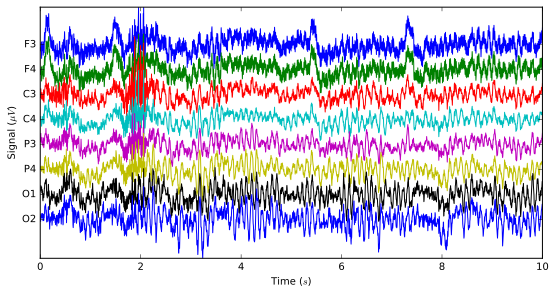

In [2]:
chanNames = ('F3','F4','C3','C4','P3','P4','O1','O2')

trials = [eeg.EEGFromPickledMatrix('s11-mentaltasks-trial' + str(i) + '.pkl',
                                   chanNames=chanNames, sampRate=256, transpose=True)
          for i in range(1,6)]

trials[0].plotTrace(0,10, scale=35)
print trials[0].getSampRate(), trials[0].getNSec()

CEBL3 uses a marker channel to identify the beginning and end of each trial.

Next, we split the data into two-second segments with 50% overlap.  This yields 45 two-second segments.

These segments are what we will examine and classify.

[45, 45, 45, 45]


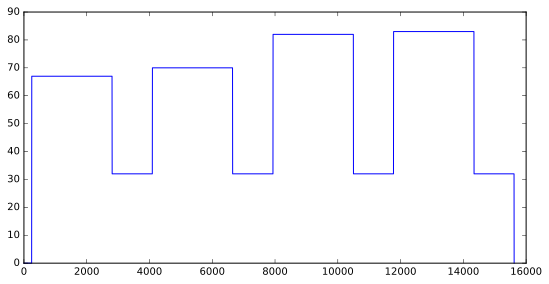

In [3]:
plt.plot(trials[0].getMarkers())

segs = [cls.segment(0,10) for cls in trials]
for trial in segs[1:]:
    segs[0].append(trial)
segs = segs[0]
    
classData = [segs.selectChr(c) for c in ('C', 'F', 'R', 'S')]
classData = [cls.split(2, 0.5) for cls in classData]

print [cls.getNSeg() for cls in classData]

One of the most straight-forward ways to construct a time-invariant representation of an EEG signal is to use the Discrete Fourier Transform (DFT) to represent the signal in the frequency domain, i.e., as a sum of sine waves in the complex domain.

By discarding the phase information and performing some scaling, we can find the Power Spectral Density (PSD) of the signal.  The PSD is time-invariant and expresses the signal in terms of signal power $(\mu V^2)$ across a range of frequencies.

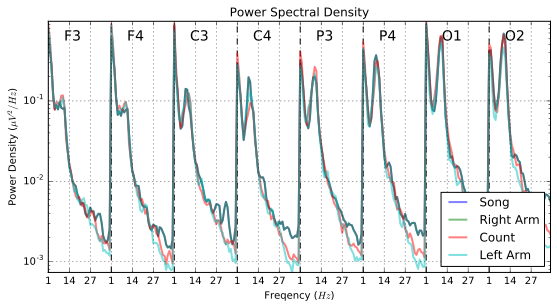

In [4]:
#psdKwargs = {'method': 'raw'}
psdKwargs = {'method': 'welch', 'span': 1.0}
classData[0].plotAvgPSDByChan(label='Song', lowFreq=0.5, highFreq=40, linewidth=2, alpha=0.5,
                              plotChanNames=False, psdKwargs=psdKwargs);
for i, label in enumerate(('Right Arm', 'Count', 'Left Arm')):
    classData[i].plotAvgPSDByChan(label=label, lowFreq=0.5, highFreq=40, linewidth=2, alpha=0.5,
                                  ax=plt.gca(), psdKwargs=psdKwargs,
                                  plotChanNames=True if label == 'Left Arm' else False);
plt.legend(loc='lower right');

Some subtle differences around the $\alpha$, $\beta$ and $\gamma$ bands.

Next, we put powers in four matrices, one row segment and col for power for each class

In [5]:
classPowers = [np.array([pwr.getPowers() for pwr in cls.psd(span=0.5)])
               for cls in classData]
freqs = classData[0].psd(span=0.5)[0].getFreqs()

highMask = freqs < 40.0
lowMask = freqs > 0.5
freqMask = lowMask & highMask

classPowers = [cls[:,freqMask,:] for cls in classPowers]

classPowers = [cls.reshape((cls.shape[0],-1), order='F') for cls in classPowers]

trainData = [np.log10(cls[:36]) for cls in classPowers]
testData = [np.log10(cls[36:]) for cls in classPowers]

print trainData[0].shape, testData[0].shape

(36, 152) (9, 152)


Classify using LDA with shrinkage toward the average eigenvalue of the average covariance matrix

In our experience, other classifiers don't do much better

Dimensionality reduced using decimation and smoothed using Welch's method

fold:  0
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
fold:  6
fold:  7
fold:  8
fold:  9
bestShrinkage:  0.55
Test Confusion Matrix:
[[ 0.7778  0.1111  0.      0.    ]
 [ 0.2222  0.7778  0.5556  0.1111]
 [ 0.      0.1111  0.2222  0.1111]
 [ 0.      0.      0.2222  0.7778]]
Test Classification Accuracy:  0.638888888889
Information Transfer Rate:  29.0430479397


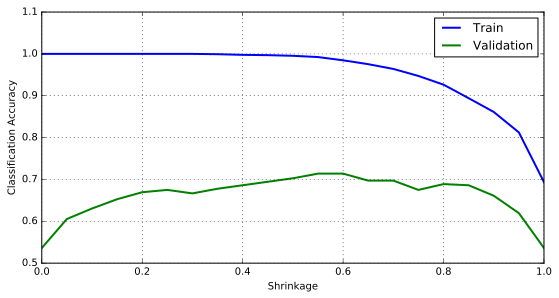

In [6]:
nFold = 10
shrinkages = np.linspace(0.0, 1.0, 21)
trnCA = np.zeros(shrinkages.shape)
valCA = np.zeros(shrinkages.shape)

for fold, trn, val in ml.part.classStratified(trainData, nFold):
    print 'fold: ', fold
    for i, sh in enumerate(shrinkages):
        model = ml.LDA(trn, shrinkage=sh)
        trnCA[i] += model.ca(trn)
        valCA[i] += model.ca(val)

trnCA /= nFold
valCA /= nFold

bestShrinkage = shrinkages[valCA.argmax()]
print 'bestShrinkage: ', bestShrinkage

model = ml.LDA(trainData, shrinkage=bestShrinkage)

print 'Test Confusion Matrix:\n', model.confusion(testData)
print 'Test Classification Accuracy: ', model.ca(testData)
print 'Information Transfer Rate: ', model.itr(testData, decisionRate=60)

plt.plot(shrinkages, trnCA, linewidth=2, label='Train')
plt.plot(shrinkages, valCA, linewidth=2, label='Validation')
plt.xlabel('Shrinkage')
plt.ylabel('Classification Accuracy')
plt.grid()
plt.legend();

PSDs have a limited ability to represent some types of patterns.  For example, phase information is discarded.

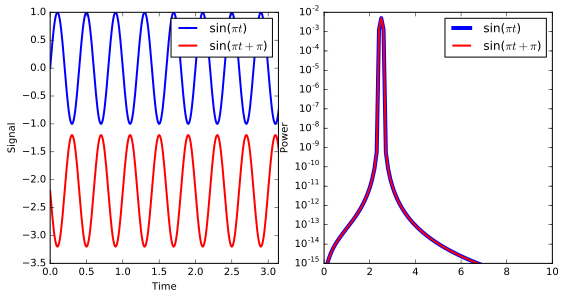

In [7]:
sampRate = 100
t = np.arange(0.0, 10.0, 1.0/sampRate)
s1 = np.sin(5*np.pi*t)
s2 = np.sin(5*np.pi*t + np.pi)

fig = plt.figure()
sigAx = fig.add_subplot(1,2,1)
sigAx.plot(t, s1, linewidth=2, label=r'sin($\pi t$)', color='blue')
sigAx.plot(t, s2-2.2, linewidth=2, label=r'sin($\pi t + \pi$)', color='red')
sigAx.set_xlim((0.0, np.pi))
sigAx.set_xlabel('Time')
sigAx.set_ylabel('Signal')
sigAx.legend()

psd1 = sig.RawPSD(s1, sampRate=sampRate)
psd2 = sig.RawPSD(s2, sampRate=sampRate)

psdAx = fig.add_subplot(1,2,2)
psd1.plotPower(linewidth=4, label=r'sin($\pi t$)', color='blue', ax=plt.gca())
psd2.plotPower(linewidth=2, label=r'sin($\pi t + \pi$)', color='red', ax=plt.gca())
psdAx.set_yscale('log')
psdAx.set_ylabel('Power')
psdAx.set_xlim((0.0, 10.0))
psdAx.set_ylim((1e-15, 1e-2))
psdAx.legend();

Also, not well-suited for representing non-linear and non-stationary patterns

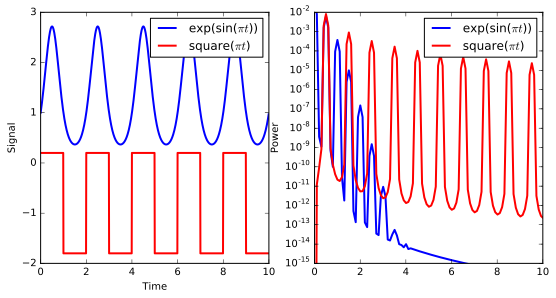

In [8]:
s1 = np.exp(np.sin(np.pi*t))
s2 = spsig.square(np.pi*t)

fig = plt.figure()
sigAx = fig.add_subplot(1,2,1)
sigAx.plot(t, s1, linewidth=2, label=r'exp(sin($\pi t$))', color='blue')
sigAx.plot(t, s2-0.8, linewidth=2, label=r'square($\pi t$)', color='red')
sigAx.set_xlim((0.0, 10.0))
sigAx.set_xlabel('Time')
sigAx.set_ylabel('Signal')
sigAx.legend()

psd1 = sig.RawPSD(s1, sampRate=sampRate)
psd2 = sig.RawPSD(s2, sampRate=sampRate)

psdAx = fig.add_subplot(1,2,2)
psd1.plotPower(linewidth=2, label=r'exp(sin($\pi t$))', color='blue', ax=psdAx)
psd2.plotPower(linewidth=2, label=r'square($\pi t$)', color='red', ax=psdAx)
psdAx.set_yscale('log')
psdAx.set_ylabel('Power')
psdAx.set_xlim((0.0, 10.0))
psdAx.set_ylim((1e-15, 1e-2))
psdAx.legend();

Autoregressive (AR) models are another approach for constructing time-invariant representations.  AR models represent each signal value as a function of past values.  In general, this can be written as


$$\mathbf{S}(t) = f(\mathbf{S}(t-1), \mathbf{S}(t-2), \ldots, \mathbf{S}(t-d)) + \mathbf{\xi}(t)$$

Where $\mathbf{S}(t)$ is a vector of signal values at time $t$, $d$ is the model order, $f$ is a chosen transfer function and $\mathbf{\bar{\xi}}(t)$ is the vector of model residuals.


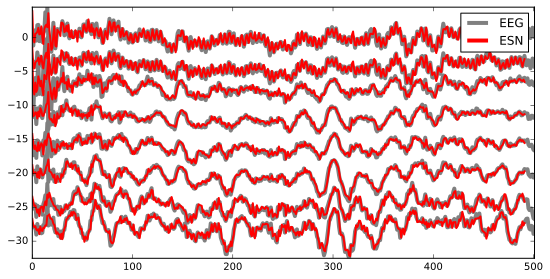

In [9]:
trainData = [cls.data[:36] for cls in classData]
testData = [cls.data[36:] for cls in classData]

stand = ml.ClassSegStandardizer(trainData)
trainData = stand.apply(trainData)
testData = stand.apply(testData)

order = 10
model = ml.AR(trainData[0], order=order)
preds, resids = model.eval(trainData[0], returnResid=True)

sep = util.colsep(trainData[0][1], scale=2.0)
plt.plot(trainData[0][1][order:] + sep, color='grey', linewidth=4)
plt.plot(preds[1][:-order] + sep, color='red', linewidth=2)
legend = plt.legend(['EEG', 'ESN'])
legend.legendHandles[1].set_color('red')
plt.autoscale(tight=True)

One approach for using AR models to perform classification is to use the residuals, $\mathbf{\xi}(t)$, as a measure of goodness-of-fit.

* train a separate AR model for each class
* for new data, apply each model
* assign label associated with model that produced lowest forecasting error (generative approach)

fold:  0
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
fold:  6
fold:  7
fold:  8
fold:  9
bestOrder:  8
Test Confusion Matrix:
[[ 0.8889  0.      0.      0.    ]
 [ 0.1111  1.      0.      0.    ]
 [ 0.      0.      0.8889  0.4444]
 [ 0.      0.      0.1111  0.5556]]
Test Classification Accuracy:  0.833333333333
Information Transfer Rate:  65.1490296939


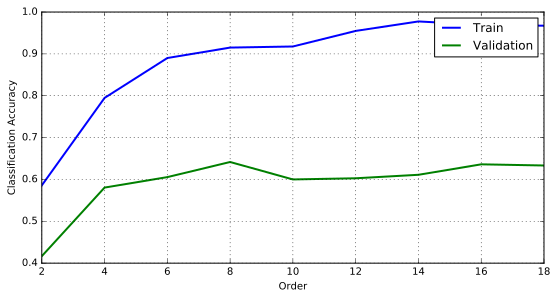

In [10]:
nFold = 10
orders = np.arange(2,20,2)
trnCA = np.zeros(orders.shape)
valCA = np.zeros(orders.shape)

for fold, trn, val in ml.part.classStratified(trainData, nFold):
    print 'fold: ', fold
    for i, order in enumerate(orders):
        model = ml.ARC(trn, order=order)
        trnCA[i] += model.ca(trn)
        valCA[i] += model.ca(val)
        
trnCA /= nFold
valCA /= nFold

bestOrder = orders[valCA.argmax()]
print 'bestOrder: ', bestOrder

model = ml.ARC(trainData, order=bestOrder)
print 'Test Confusion Matrix:\n', model.confusion(testData)
print 'Test Classification Accuracy: ', model.ca(testData)
print 'Information Transfer Rate: ', model.itr(testData, decisionRate=60)

plt.plot(orders, trnCA, linewidth=2, label='Train')
plt.plot(orders, valCA, linewidth=2, label='Validation')
plt.xlabel('Order')
plt.ylabel('Classification Accuracy')
plt.grid()
plt.legend();

We have also tried various other types of forecasting models, including non-linear models with feedforward nets and also recurrent networks.

Ask me about these models later if you are interested.

Of course, we could also pass the time-embedded features directly to a classifier that estimates the class probabilities at each timestep

$$P(C = K)(t) = g(\mathbf{S}(t-1), \mathbf{S}(t-2), \ldots, \mathbf{S}(t-d))$$

where $g$ can be any classifier that outputs probabilities, e.g., a neural network.

Some form of evidence accumulation is needed to assign labels after a reasonable interval of time has passed.  This could be voting or summing the log likelihoods or something more sophisticated, e.g., MSPRT.

This approach is something that we have been looking at for quite some time and our group has published several papers using this approach.

Recently, we have noted that if this idea is repeated for multiple layers, with decimation inbetween, we have a type of convolutional network.

<img src="cnn_logsum2.svg" width="80%"/>

In [11]:
trainData = [cls.data[:36] for cls in classData]
testData = [cls.data[36:] for cls in classData]

stand = ml.ClassSegStandardizer(trainData)
trainData = stand.apply(trainData)
testData = stand.apply(testData)

fold:  0
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
fold:  6
fold:  7
fold:  8
fold:  9
bestIter:  474
Test Confusion Matrix:
[[ 1.      0.      0.      0.    ]
 [ 0.      0.7778  0.1111  0.    ]
 [ 0.      0.2222  0.5556  0.    ]
 [ 0.      0.      0.3333  1.    ]]
Test Classification Accuracy:  0.833333333333
Information Transfer Rate:  65.1490296939


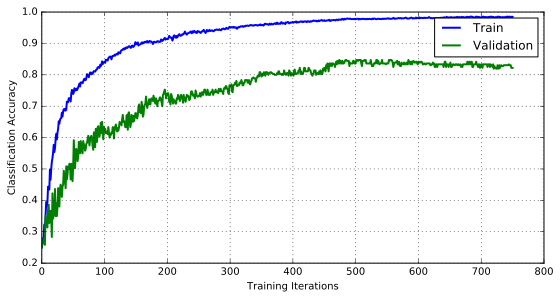

In [12]:
nFold = 10
maxIter = 750
convs = ((8,16),(16,8))

trnCA = np.zeros((nFold,maxIter+1))
valCA = np.zeros((nFold,maxIter+1))
seed = np.random.randint(0, 1000000)

for fold, trn, val in ml.part.classStratified(trainData, nFold):
    print 'fold: ', fold
    def valCB(optable, iteration, paramTrace, errorTrace, success=True):
        if not success: return
        trnCA[fold,valCB.it:] = optable.ca(trn)
        valCA[fold,valCB.it:] = optable.ca(val)
        valCB.it += 1
    valCB.it = 0

    np.random.seed(seed)
    model = ml.TDENS(trn, convs=convs, verbose=False,
                     accuracy=0.0, precision=1.0e-10,
                     maxIter=maxIter, callback=valCB,
                     accum=2, phi=ml.transfer.lecun)
        
trnCA = trnCA.mean(axis=0)
valCA = valCA.mean(axis=0)

bestIter = valCA.argmax()
print 'bestIter: ', bestIter

np.random.seed(seed)
model = ml.TDENS(trainData, convs=convs,
                 accuracy=0.0, precision=1.0e-10,
                 maxIter=bestIter,
                 accum=2, phi=ml.transfer.lecun)
print 'Test Confusion Matrix:\n', model.confusion(testData)
print 'Test Classification Accuracy: ', model.ca(testData)
print 'Information Transfer Rate: ', model.itr(testData, decisionRate=60)

plt.plot(trnCA, linewidth=2, label='Train')
plt.plot(valCA, linewidth=2, label='Validation')
plt.xlabel('Training Iterations')
plt.ylabel('Classification Accuracy')
plt.grid()
plt.legend();

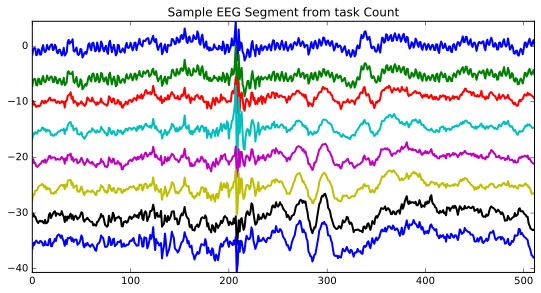

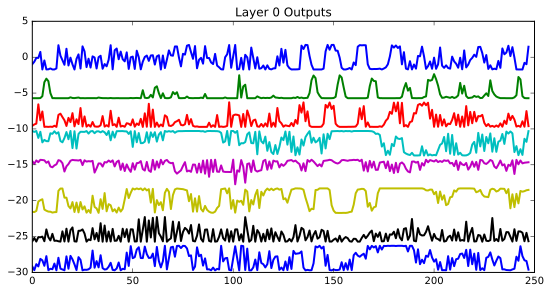

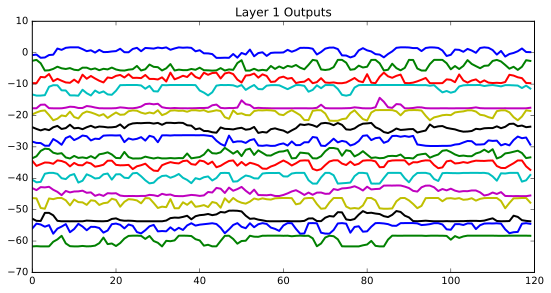

In [13]:
layerOuts = model.evalConvs(testData[0])

plt.plot(testData[0][0] + util.colsep(testData[0][0], scale=2.5), linewidth=2)
plt.autoscale(tight=True)
plt.title('Sample EEG Segment from task Count')

for i, outs in enumerate(layerOuts):
    plt.figure()
    plt.plot(outs[0] + util.colsep(outs[0], scale=2), linewidth=2)
    #plt.autoscale(tight=True)
    plt.title('Layer ' + str(i) + ' Outputs')

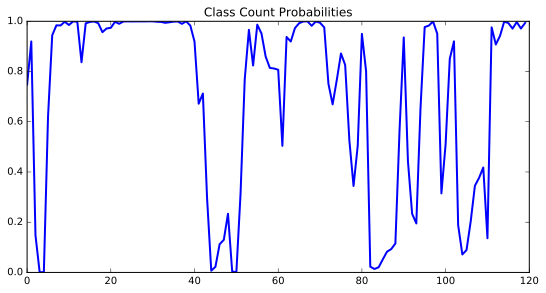

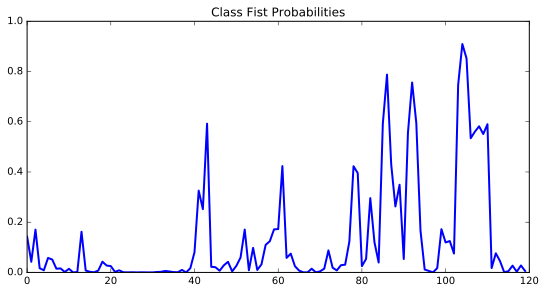

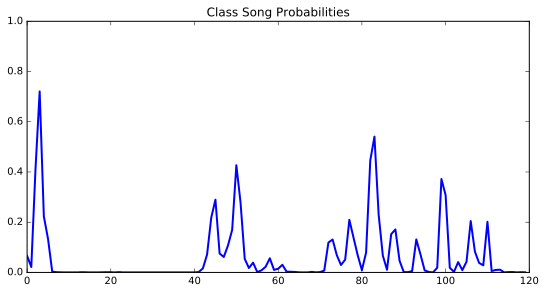

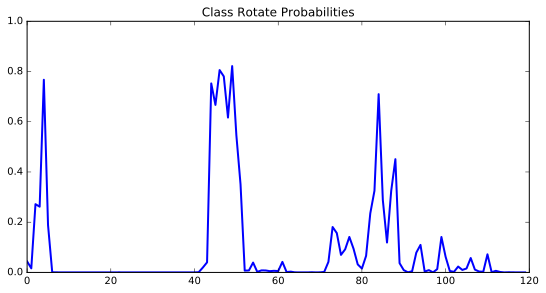

In [14]:
logLike = model.logLikelihood(testData[0])
probs = np.exp(logLike[0])

for p, c in zip(probs.T, ('Count', 'Fist', 'Song', 'Rotate')):
    plt.figure()
    plt.plot(p, linewidth=2)
    plt.title('Class ' + c + ' Probabilities')
    plt.ylim((0,1))